# Import libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Importing dataset

In [ ]:
data = pd.read_csv('data/frc-match-history.csv')

# Preview dataset

In [ ]:
data.head()

,match_key,event_key,year,comp_level,match_number,match_level,actual_time,post_result_time,predicted_time,set_number,...,red_3_epa_trend,blue_1_win_rate,blue_1_win_streak,blue_1_epa_trend,blue_2_win_rate,blue_2_win_streak,blue_2_epa_trend,blue_3_win_rate,blue_3_win_streak,blue_3_epa_trend
0,2018abca_qm1,2018abca,2018,qm,1,1,1523028258,1.523028e+09,1.523028e+09,1,...,-32.540000,1.0,1,0.000000,1.000,5,-8.690000,0.333333,1,-6.695000
1,2018abca_qm2,2018abca,2018,qm,2,1,1523028707,1.523029e+09,1.523029e+09,1,...,-28.000000,0.8,2,-12.020000,1.000,4,-1.859000,0.600000,3,-0.115000
2,2018abca_qm3,2018abca,2018,qm,3,1,1523029497,1.523030e+09,1.523030e+09,1,...,-0.418000,0.6,3,-2.844000,0.400,1,-1.083000,0.666667,1,-1.999833
3,2018abca_qm4,2018abca,2018,qm,4,1,1523030028,1.523030e+09,1.523030e+09,1,...,2.602143,0.6,1,-4.289000,0.250,1,-0.859405,0.444444,1,-2.443333
4,2018abca_qm5,2018abca,2018,qm,5,1,1523030468,1.523031e+09,1.523031e+09,1,...,-1.761818,0.6,0,-0.673879,0.125,0,-0.010000,0.900000,0,-1.141455


# Check for missing values

In [ ]:
data.isnull().sum()

,0
match_key,0
event_key,0
year,0
comp_level,0
match_number,0
...,...
blue_2_win_streak,0
blue_2_epa_trend,0
blue_3_win_rate,0
blue_3_win_streak,0


# Define model features

In [ ]:
features = [
    'year', 'event_key', 'comp_level', 'match_number',
    'red_1_win_rate', 'red_2_win_rate', 'red_3_win_rate', 'blue_1_win_rate',
    'blue_2_win_rate', 'blue_3_win_rate', 'red_1_epa_trend', 'red_2_epa_trend',
    'red_3_epa_trend', 'blue_1_epa_trend', 'blue_2_epa_trend', 'blue_3_epa_trend',
    'epa_diff','epa_ratio'
]

# Create target data

In [ ]:
data['red_win'] = (data['score_dif'] > 0).astype(int)

target = 'red_win'

 # Declare feature vector and target

In [ ]:
X = data[features]
y = data[target]

X = pd.get_dummies(X, columns=['event_key', 'comp_level'], drop_first=True)

In [ ]:
X.head()

,year,match_number,red_1_win_rate,red_2_win_rate,red_3_win_rate,blue_1_win_rate,blue_2_win_rate,blue_3_win_rate,red_1_epa_trend,red_2_epa_trend,...,event_key_2025mimtp,event_key_2025mimus,event_key_2025misal,event_key_2025misjo,event_key_2025mitry,event_key_2025mitvc,event_key_2025miwmi,comp_level_qf,comp_level_qm,comp_level_sf
0,2018,1,0.000000,0.000000,0.000000,1.0,1.000,0.333333,0.000000,0.000000,...,False,False,False,False,False,False,False,False,True,False
1,2018,2,0.285714,0.750000,0.000000,0.8,1.000,0.600000,0.746786,-1.989000,...,False,False,False,False,False,False,False,False,True,False
2,2018,3,0.285714,0.250000,0.333333,0.6,0.400,0.666667,-3.195000,-7.867000,...,False,False,False,False,False,False,False,False,True,False
3,2018,4,0.142857,0.500000,0.000000,0.6,0.250,0.444444,-1.139286,0.006000,...,False,False,False,False,False,False,False,False,True,False
4,2018,5,0.833333,0.727273,1.000000,0.6,0.125,0.900000,-3.040385,-1.205818,...,False,False,False,False,False,False,False,False,True,False


In [ ]:
y.head()

,red_win
0,0
1,0
2,0
3,0
4,1


# Handle missing values

In [ ]:
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)

# Scale characteristics

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Save column names and reconstruct dataframe

In [ ]:
# Guardar los nombres de las columnas antes de la transformación
column_names = X.columns

# Reconstruir el DataFrame con los nombres de las columnas
X_transformed = pd.DataFrame(X_scaled, columns=column_names)

# Split into training and test data

In [ ]:
# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=42)


# Train the XGBClassifier model

In [ ]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:32:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

# Make predictions with XGBCLassifier

In [ ]:
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

y_pred = (y_pred_proba > 0.5).astype(int)

# Check performance

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'Accuracy: {accuracy}')
print(f'ROC AUC: {roc_auc}')

Accuracy: 0.9222605465640753
ROC AUC: 0.9788171111338743


# Feature Importance

<Figure size 1200x600 with 0 Axes>

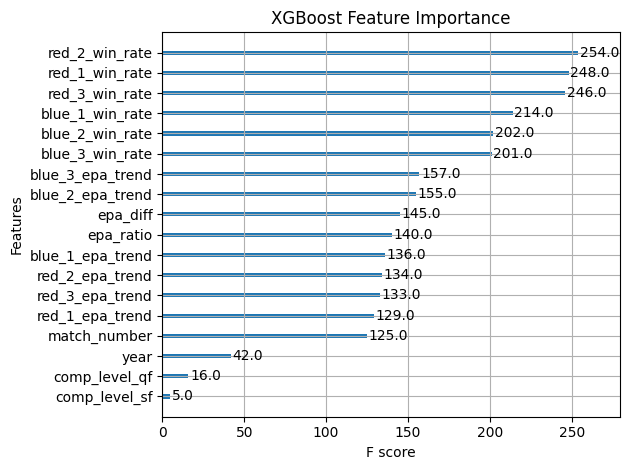

In [ ]:
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=18)  # Pass the trained XGBClassifier model
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

# Save model



In [ ]:
with open('xgbclassifier.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save the imputer
with open('imputer.pkl', 'wb') as f:
    pickle.dump(imputer, f)

# Save the scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)